# Análise de Redes Sociais dos Perfis Socioeconômicos dos Beneficiários do Programa Bolsa Família no Brasil

# 1. Coleta dos dados e Limpeza dos dados

## 1.1 Coletando os dados

In [17]:
# Instalando os pacotes
install.packages(c(
  "igraph",
  "tidygraph",
  "ggraph",
  "dplyr",
  "tidyr",
  "ggplot2"
))

Warning message:
"os pacotes 'igraph', 'dplyr', 'tidyr', 'ggplot2' estão em uso e não serão instalados"
Instalando pacotes em 'C:/Users/mauri/AppData/Local/R/win-library/4.5'
(como 'lib' não foi especificado)

instalando as dependências 'tweenr', 'polyclip', 'Rcpp', 'gridExtra', 'RcppArmadillo', 'ggforce', 'ggrepel', 'viridis', 'graphlayouts' também




pacote 'tweenr' desempacotado com sucesso e somas MD5 verificadas
pacote 'polyclip' desempacotado com sucesso e somas MD5 verificadas
pacote 'Rcpp' desempacotado com sucesso e somas MD5 verificadas
pacote 'gridExtra' desempacotado com sucesso e somas MD5 verificadas
pacote 'RcppArmadillo' desempacotado com sucesso e somas MD5 verificadas
pacote 'ggforce' desempacotado com sucesso e somas MD5 verificadas
pacote 'ggrepel' desempacotado com sucesso e somas MD5 verificadas
pacote 'viridis' desempacotado com sucesso e somas MD5 verificadas
pacote 'graphlayouts' desempacotado com sucesso e somas MD5 verificadas
pacote 'tidygraph' desempacotado com sucesso e somas MD5 verificadas
pacote 'ggraph' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\mauri\AppData\Local\Temp\Rtmp4qpmve\downloaded_packages


In [18]:
# Carregando pacotes

# Manipulação
library(dplyr)
library(tidyr)
library(Matrix)

# Redes
library(igraph)
library(tidygraph)
library(ggraph)

# Visualização
library(ggplot2)


Anexando pacote: 'tidygraph'


O seguinte objeto é mascarado por 'package:igraph':

    groups


O seguinte objeto é mascarado por 'package:stats':

    filter




In [3]:
###############################################################################
# 0) PACOTES
library(tidyverse)
library(readr)
library(dplyr)

###############################################################################
# 1) Caminho dos dados
caminho_dados <- "C:/Users/mauri/Downloads/Dados_POF_2017-2018"

###############################################################################
# 2) MORADOR — extrai chefe e cria chaves
morador <- read_fwf(
  file = file.path(caminho_dados,"MORADOR.txt"),
  col_positions = fwf_positions(
    start=c(1,3,8,17,19,20,22,24,25,27,29,33,36,37,39,48,49,68,75,76,78,92,106,116,117,118),
    end  =c(2,6,16,18,19,21,23,24,26,28,32,35,36,37,39,48,49,69,75,77,91,105,115,116,117,137),
    col_names=c(
      "UF","EXTRATO","CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO",
      "NUMERO_INFORMANTE","CONDICAO_UNIDADE_CONSUMO","PRESENCA_MOMENTO_PESQUISA","DIA_NASCIMENTO",
      "MES_NASCIMENTO","ANO_NASCIMENTO","IDADE","SEXO","RACA","RENDIMENTO_TRABALHO","SABE_LER_ESCREVER",
      "FREQUENTA_ESCOLA_CRECHE","NIVEL_EDUCACAO","CONCLUIU_ESTUDOS","ANOS_ESTUDOS","FATOR_EXPANSAO",
      "FATOR_EXPANSAO2","RENDA_TOTAL","NIVEL_DE_INSTRUCAO","RENDA_DISPONIVEL_FAMILIAR_PER_CAPITA",
      "RENDA_PER_CAPITA"
    )
  ),
  locale=locale(encoding="Latin1"),
  col_types=cols(.default="c")
)

morador <- morador %>%
  mutate(across(
    c(CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO,
      NUMERO_INFORMANTE, CONDICAO_UNIDADE_CONSUMO, IDADE),
    as.numeric
  )) %>%
  filter(CONDICAO_UNIDADE_CONSUMO == 1)   # mantém apenas o chefe da UC

###############################################################################
# 3) DOMICILIO
domicilio <- read_fwf(
  file = file.path(caminho_dados,"DOMICILIO.txt"),
  col_positions = fwf_positions(
    start=c(8,17, 7,19,20,21,22,23,26,34,38,40,43,44,46,47,79),
    end  =c(16,18, 7,19,20,21,22,24,26,34,38,40,43,44,46,47,79),
    col_names=c(
      "CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO",
      "SITUACAO_DOMICILIO","TIPO_DOMICILIO","MATERIAL_PAREDES","MATERIAL_TELHADO","MATERIAL_PISO",
      "QUANTIDADE_COMODOS","ABASTECIMENTO_AGUA","BANHEIRO_USO_EXCLUSIVO","ESCOADOURO","ENERGIA_REDE_GERAL",
      "BOTIJAO_ENCANADO","FOGAO_LENHA_CARVAO","FOGAO_OUTRO","DOMICILIO_ALUGADO","SEGURANCA_ALIMENTAR"
    )
  ),
  locale=locale(encoding="Latin1"),
  col_types=cols(.default="c")
) %>%
  mutate(across(c(CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO), as.numeric))

###############################################################################
# 4) MORADOR QUALIDADE VIDA + CONDICOES VIDA
quali <- read_fwf(
  file=file.path(caminho_dados,"MORADOR_QUALI_VIDA.txt"),
  col_positions=fwf_positions(
    start=c(8,17,19,20,113),
    end  =c(16,18,19,21,113),
    col_names=c(
      "CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO",
      "NUMERO_INFORMANTE","GRANDE_REGIAO"
    )
  ),
  locale=locale(encoding="Latin1"),
  col_types=cols(.default="c")
) %>%
  mutate(across(
    c(CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO, NUMERO_INFORMANTE),
    as.numeric
  ))

cond <- read_fwf(
  file=file.path(caminho_dados,"CONDICOES_VIDA.txt"),
  col_positions=fwf_positions(
    start=c(8,17,19,62,63,64),
    end  =c(16,18,19,62,63,64),
    col_names=c(
      "CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO",
      "PREOCUPACAO_ALIMENTO_ACABAR","ALIMENTOS_ACABARAM","SEM_DINHEIRO_ALIMENTACAO_VARIADA"
    )
  ),
  locale=locale(encoding="Latin1"),
  col_types=cols(.default="c")
) %>%
  mutate(across(c(CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO), as.numeric))

quali_vida <- quali %>%
  left_join(cond,
            by=c("CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO"))

###############################################################################
# 5) OUTROS RENDIMENTOS — agora pegando TODOS os valores
outros_rend <- read_fwf(
  file = file.path(caminho_dados, "OUTROS_RENDIMENTOS.txt"),
  col_positions = fwf_positions(
    start = c(8,17,19,26),
    end   = c(16,18,19,32),
    col_names = c(
      "CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO",
      "TIPO_RENDIMENTO"
    )
  ),
  locale = locale(encoding="Latin1"),
  col_types = cols(.default="c")
) %>%
  mutate(across(
    c(CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO),
    as.numeric
  ))

# Mantém todos os tipos V9001, sem filtragem
outros_rend_all <- outros_rend %>%
  distinct(
    CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO,
    TIPO_RENDIMENTO,
    .keep_all = TRUE
  )

###############################################################################
# 6) MERGE FINAL
dados_pof_2018 <- morador %>%
  left_join(domicilio,
            by=c("CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO")) %>%
  left_join(quali_vida,
            by=c("CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO",
                 "NUMERO_UNIDADE_CONSUMO","NUMERO_INFORMANTE")) %>%
  left_join(outros_rend_all,
            by=c("CODIGO_UNIDADE_PRIMARIA","NUMERO_DOMICILIO","NUMERO_UNIDADE_CONSUMO"))

###############################################################################
# 7) REORDENA as colunas EXATAMENTE como você pediu
dados_pof_2018 <- dados_pof_2018 %>%
  select(
    UF, NUMERO_INFORMANTE, GRANDE_REGIAO, SEXO, RACA, ANOS_ESTUDOS, NIVEL_DE_INSTRUCAO,
    IDADE, ANO_NASCIMENTO, DIA_NASCIMENTO, MES_NASCIMENTO,
    EXTRATO, CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO,
    CONDICAO_UNIDADE_CONSUMO, PRESENCA_MOMENTO_PESQUISA, SABE_LER_ESCREVER,
    FREQUENTA_ESCOLA_CRECHE, NIVEL_EDUCACAO, CONCLUIU_ESTUDOS, RENDIMENTO_TRABALHO,
    RENDA_DISPONIVEL_FAMILIAR_PER_CAPITA, FATOR_EXPANSAO, FATOR_EXPANSAO2,
    SITUACAO_DOMICILIO, TIPO_DOMICILIO, MATERIAL_PAREDES, MATERIAL_TELHADO,
    MATERIAL_PISO, QUANTIDADE_COMODOS, ABASTECIMENTO_AGUA,
    BANHEIRO_USO_EXCLUSIVO, ESCOADOURO, ENERGIA_REDE_GERAL,
    BOTIJAO_ENCANADO, FOGAO_LENHA_CARVAO, FOGAO_OUTRO, DOMICILIO_ALUGADO,
    PREOCUPACAO_ALIMENTO_ACABAR, ALIMENTOS_ACABARAM, SEM_DINHEIRO_ALIMENTACAO_VARIADA,
    RENDA_TOTAL, RENDA_PER_CAPITA, TIPO_RENDIMENTO, SEGURANCA_ALIMENTAR
  )

###############################################################################
# 8) MOSTRA AS 10 PRIMEIRAS LINHAS
head(as.data.frame(dados_pof_2018), 10)


,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPO_RENDIMENTO,SEGURANCA_ALIMENTAR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5400501,1
2,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500401,1
3,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500101,1
4,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500201,1
5,11,1,1,2,4,12,5,37,1980,4,⋯,2,2,1,2,2,2,4242.48,1265.6441666667,NA,1
6,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5400401,4
7,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5500201,4
8,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5400101,1
9,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5401601,1


## 1.2 Quantidade de linhas e colunas

In [64]:
# RESUMO → LINHAS E COLUNAS SEPARADOS
###############################################################################
resumo_df <- data.frame(
  Linhas = nrow(dados_pof_2018),
  Colunas = ncol(dados_pof_2018)
)

resumo_df

Linhas,Colunas
<int>,<int>
180624,46


## 1.3 Nomes de todas as colunas da base de dados

In [65]:
names(dados_pof_2018)

[1] "UF"                                  
 [2] "NUMERO_INFORMANTE"                   
 [3] "GRANDE_REGIAO"                       
 [4] "SEXO"                                
 [5] "RACA"                                
 [6] "ANOS_ESTUDOS"                        
 [7] "NIVEL_DE_INSTRUCAO"                  
 [8] "IDADE"                               
 [9] "ANO_NASCIMENTO"                      
[10] "DIA_NASCIMENTO"                      
[11] "MES_NASCIMENTO"                      
[12] "EXTRATO"                             
[13] "CODIGO_UNIDADE_PRIMARIA"             
[14] "NUMERO_DOMICILIO"                    
[15] "NUMERO_UNIDADE_CONSUMO"              
[16] "CONDICAO_UNIDADE_CONSUMO"            
[17] "PRESENCA_MOMENTO_PESQUISA"           
[18] "SABE_LER_ESCREVER"                   
[19] "FREQUENTA_ESCOLA_CRECHE"             
[20] "NIVEL_EDUCACAO"                      
[21] "CONCLUIU_ESTUDOS"                    
[22] "RENDIMENTO_TRABALHO"                 
[23] "RENDA_DISPONIVEL_FAMILIAR_PER_CAPITA"
[24] "FATOR_EXPANSAO"                      
[25] "FATOR_EXPANSAO2"                     
[26] "SITUACAO_DOMICILIO"                  
[27] "TIPO_DOMICILIO"                      
[28] "MATERIAL_PAREDES"                    
[29] "MATERIAL_TELHADO"                    
[30] "MATERIAL_PISO"                       
[31] "QUANTIDADE_COMODOS"                  
[32] "ABASTECIMENTO_AGUA"                  
[33] "BANHEIRO_USO_EXCLUSIVO"              
[34] "ESCOADOURO"                          
[35] "ENERGIA_REDE_GERAL"                  
[36] "BOTIJAO_ENCANADO"                    
[37] "FOGAO_LENHA_CARVAO"                  
[38] "FOGAO_OUTRO"                         
[39] "DOMICILIO_ALUGADO"                   
[40] "PREOCUPACAO_ALIMENTO_ACABAR"         
[41] "ALIMENTOS_ACABARAM"                  
[42] "SEM_DINHEIRO_ALIMENTACAO_VARIADA"    
[43] "RENDA_TOTAL"                         
[44] "RENDA_PER_CAPITA"                    
[45] "TIPO_RENDIMENTO"                     
[46] "SEGURANCA_ALIMENTAR"

## 1.4 Verificando a existência de valores nulos

In [ ]:
# CONTAR NULOS POR COLUNA

nulos_df <- data.frame(

  Colunas = names(dados_causal_forest),

  Quantidade_de_Nulos = sapply(dados_causal_forest, function(x) sum(is.na(x) | x == ""))
)

nulos_df

## 1.5 Removendo as colunas com valores nulos

In [5]:
dados_pof_2018_1 <- dados_pof_2018 %>%
  select(
    -NIVEL_EDUCACAO,
    -CONCLUIU_ESTUDOS,
    -RENDIMENTO_TRABALHO,
    -RENDA_DISPONIVEL_FAMILIAR_PER_CAPITA,
    -BANHEIRO_USO_EXCLUSIVO,
    -ESCOADOURO
  )
head(as.data.frame(dados_pof_2018_1), 10)

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPO_RENDIMENTO,SEGURANCA_ALIMENTAR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5400501,1
2,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500401,1
3,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500101,1
4,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500201,1
5,11,1,1,2,4,12,5,37,1980,4,⋯,2,2,1,2,2,2,4242.48,1265.6441666667,NA,1
6,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5400401,4
7,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5500201,4
8,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5400101,1
9,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5401601,1


## 1.6 Nomes de todas as colunas após a remoção das colunas com valores nulos

In [6]:
names(dados_pof_2018_1)

[1] "UF"                               "NUMERO_INFORMANTE"               
 [3] "GRANDE_REGIAO"                    "SEXO"                            
 [5] "RACA"                             "ANOS_ESTUDOS"                    
 [7] "NIVEL_DE_INSTRUCAO"               "IDADE"                           
 [9] "ANO_NASCIMENTO"                   "DIA_NASCIMENTO"                  
[11] "MES_NASCIMENTO"                   "EXTRATO"                         
[13] "CODIGO_UNIDADE_PRIMARIA"          "NUMERO_DOMICILIO"                
[15] "NUMERO_UNIDADE_CONSUMO"           "CONDICAO_UNIDADE_CONSUMO"        
[17] "PRESENCA_MOMENTO_PESQUISA"        "SABE_LER_ESCREVER"               
[19] "FREQUENTA_ESCOLA_CRECHE"          "FATOR_EXPANSAO"                  
[21] "FATOR_EXPANSAO2"                  "SITUACAO_DOMICILIO"              
[23] "TIPO_DOMICILIO"                   "MATERIAL_PAREDES"                
[25] "MATERIAL_TELHADO"                 "MATERIAL_PISO"                   
[27] "QUANTIDADE_COMODOS"               "ABASTECIMENTO_AGUA"              
[29] "ENERGIA_REDE_GERAL"               "BOTIJAO_ENCANADO"                
[31] "FOGAO_LENHA_CARVAO"               "FOGAO_OUTRO"                     
[33] "DOMICILIO_ALUGADO"                "PREOCUPACAO_ALIMENTO_ACABAR"     
[35] "ALIMENTOS_ACABARAM"               "SEM_DINHEIRO_ALIMENTACAO_VARIADA"
[37] "RENDA_TOTAL"                      "RENDA_PER_CAPITA"                
[39] "TIPO_RENDIMENTO"                  "SEGURANCA_ALIMENTAR"

## 1.7 Removendo todas as linhas da coluna TIPO_RENDIMENTO com valores nulos

In [9]:
library(dplyr)

# Filtra a base mantendo apenas quem TEM algum valor em TIPO_RENDIMENTO
# A lógica é: NÃO pode ser NA ( !is.na ) E ( & ) NÃO pode ser vazio ( != "" )
dados_pof_2018_1 <- dados_pof_2018_1 %>%
  filter(!is.na(TIPO_RENDIMENTO) & TIPO_RENDIMENTO != "")
head(as.data.frame(dados_pof_2018_1), 10)

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPO_RENDIMENTO,SEGURANCA_ALIMENTAR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5400501,1
2,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500401,1
3,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500101,1
4,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,5500201,1
5,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5400401,4
6,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,5500201,4
7,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5400101,1
8,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5401601,1
9,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,5402301,1


## 1.8 Quantidade de linhas e colunas após a remoção das colunas e linhas com valores nulos

In [10]:
# RESUMO → LINHAS E COLUNAS SEPARADOS
###############################################################################
resumo_df_1 <- data.frame(
  Linhas = nrow(dados_pof_2018),
  Colunas = ncol(dados_pof_2018)
)

resumo_df_1

Linhas,Colunas
<int>,<int>
180624,46


## 1.9 Listando todos os valores únicos da coluna TIPO_RENDIMENTO

In [11]:
unique(dados_pof_2018_1$TIPO_RENDIMENTO)

[1] "5400501" "5500401" "5500101" "5500201" "5400401" "5400101" "5401601"
  [8] "5402301" "5500801" "5502301" "5700101" "5402101" "5501501" "5600101"
 [15] "5501001" "5400901" "5506201" "5401801" "5502201" "5401401" "5501701"
 [22] "5506701" "5502401" "5500301" "5401101" "5500901" "5501901" "5502601"
 [29] "5402601" "5400601" "5500501" "5401701" "5600401" "5501301" "5501601"
 [36] "5401301" "5502501" "5502101" "5401201" "5503601" "5500601" "5504901"
 [43] "5400801" "5401901" "5402602" "5401001" "5400201" "5700401" "5501801"
 [50] "5504101" "5600301" "5400701" "5501101" "5600201" "5700201" "5501201"
 [57] "5501401" "5503902" "5502001" "5400301" "5503901" "5504501" "5403001"
 [64] "5402001" "5500102" "5504002" "5402201" "5400307" "5502701" "5500701"
 [71] "5400313" "5502801" "5400316" "5502628" "5400317" "5401501" "5400102"
 [78] "5403501" "5502626" "5400107" "5700301" "5502630" "5400105" "5401502"
 [85] "5402501" "5505301" "5503501" "5400104" "5503101" "5504601" "5503001"
 [92] "5503903" "5505801" "5506001" "5503801" "5501402" "5400315" "5504001"
 [99] "5506101" "5502634" "5402401" "5505802" "5505401" "5500103" "5402008"
[106] "5504401" "5502901" "5403101" "5402604" "5503603" "5501602" "5502606"
[113] "5402701" "5506301" "5502619" "5506601" "5402005" "5505701" "5402007"
[120] "5502613" "5402002" "5502625" "5403401" "5400304" "5503602" "5402603"
[127] "5503301" "5502622" "5506401" "5402901" "5501702" "5400314" "5502603"
[134] "5400310" "5402003" "5506501" "5403301" "5502616" "5502612" "5503201"
[141] "5504701" "5504801" "5402006" "5505102" "5403201" "5505101" "5503403"
[148] "5502617" "5400303" "5505201" "5402801" "5502608" "5505001" "5502627"
[155] "5504301" "5400308" "5502620"

## 1.10 Extraindo os nomes exatos da coluna TIPO_RENDIMENTO

In [12]:
# Carregando bibliotecas
library(readxl)
library(dplyr)

# 1. Defina o caminho e a lista de códigos
caminho_excel <- "C:/Users/mauri/Downloads/Dados_POF_2017-2018/Cadastro de Produtos.xls"

codigos_encontrados <- c(
  '5400501','5500401','5500101','5500201','5400401','5400101','5401601','5402301',
  '5500801','5502301','5700101','5402101','5501501','5600101','5501001','5400901',
  '5506201','5401801','5502201','5401401','5501701','5506701','5502401','5500301',
  '5401101','5500901','5501901','5502601','5402601','5400601','5500501','5401701',
  '5600401','5501301','5501601','5401301','5502501','5502101','5401201','5503601',
  '5500601','5504901','5400801','5401901','5402602','5401001','5400201','5700401',
  '5501801','5504101','5600301','5400701','5501101','5600201','5700201','5501201',
  '5501401','5503902','5502001','5400301','5503901','5504501','5403001','5402001',
  '5500102','5504002','5402201','5400307','5502701','5500701','5400313','5502801',
  '5400316','5502628','5400317','5401501','5400102','5403501','5502626','5400107',
  '5700301','5502630','5400105','5401502','5402501','5505301','5503501','5400104',
  '5503101','5504601','5503001','5503903','5505801','5506001','5503801','5501402',
  '5400315','5504001','5506101','5502634','5402401','5505802','5505401','5500103',
  '5402008','5504401','5502901','5403101','5402604','5503603','5501602','5502606',
  '5402701','5506301','5502619','5506601','5402005','5505701','5402007','5502613',
  '5402002','5502625','5403401','5400304','5503602','5402603','5503301','5502622',
  '5506401','5402901','5501702','5400314','5502603','5400310','5402003','5506501',
  '5403301','5502616','5502612','5503201','5504701','5504801','5402006','5505102',
  '5403201','5505101','5503403','5502617','5400303','5505201','5402801','5502608',
  '5505001','5502627','5504301','5400308','5502620'
)

# 2. Carregar Excel SEM MENSAGEM DE AVISO (suppressMessages)
# O suppressMessages remove o aviso "New names..."
suppressMessages(
  tabela_traducao <- read_excel(caminho_excel, col_names = FALSE) %>%
    select(CODIGO = ...2, NOME = ...3) %>%
    mutate(CODIGO = as.character(CODIGO))
)

# 3. Filtrar e Selecionar
resultado_traducao <- tabela_traducao %>%
  filter(CODIGO %in% codigos_encontrados) %>%
  select(CODIGO, NOME) %>% 
  arrange(CODIGO)

# 4. Exibir TODOS os resultados no formato DataFrame
# Removemos o head() para mostrar tudo
as.data.frame(resultado_traducao)

CODIGO,NOME
<chr>,<chr>
5400101,BOLSA-FAMILIA/PETI
5400102,BOLSA-FAMILIA
5400104,AUXILIO-GAS
5400105,BOLSA-ESCOLA
5400107,CARTAO DO PROGRAMA NACIONAL DE ACESSO A ALIMENTACAO (PNAA)
5400201,BENEFICIO DE PRESTACAO CONTINUADA (BPC - LOAS)
5400301,OUTROS PROGRAMAS DE TRANSFERENCIA DE RENDA
5400303,AUXILIO-LEITE
5400304,BOLSA-RENDA


## 1.11 Substituindo os nomes exatos da coluna TIPO_RENDIMENTO na base de dados

In [13]:
# 1. Realizar a substituição (Join + Renomear)
dados_pof_2018__2 <- dados_pof_2018_1 %>%
  # Cruza com a tabela de tradução usando a coluna de código comum
  left_join(resultado_traducao, by = c("TIPO_RENDIMENTO" = "CODIGO")) %>%
  
  # A coluna 'NOME' veio da tabela de tradução. Vamos colocá-la no lugar de TIPO_RENDIMENTO.
  mutate(TIPO_RENDIMENTO = NOME) %>%
  
  # Remove a coluna auxiliar 'NOME' para não ficar duplicado
  select(-NOME)

# 2. Visualizar o resultado para confirmar
head(as.data.frame(dados_pof_2018__2), 10)

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPO_RENDIMENTO,SEGURANCA_ALIMENTAR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,PENSAO DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL),1
2,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,"13°, 14°, ETC. SALARIO DE PENSAO DO INSS",1
3,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS),1
4,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,2,3855.34,1237.1830555556,"13°, 14°, ETC. SALARIO DE TRABALHO",1
5,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,APOSENTADORIA DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL),4
6,11,1,1,2,4,5,2,65,1952,4,⋯,2,2,1,1,1,1,2669.57,1317.6766666667,"13°, 14°, ETC. SALARIO DE TRABALHO",4
7,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,BOLSA-FAMILIA/PETI,1
8,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,AUXILIO/TIQUETE/CARTAO ALIMENTACAO,1
9,11,1,1,2,4,12,5,45,1972,21,⋯,2,2,1,2,2,2,12943.65,1965.7610000000,CESTA BASICA (EM DINHEIRO),1


## 1.12 Criando a coluna RECEBE_BF a partir da coluna TIPO_RENDIMENTO

In [17]:
library(dplyr)

# Definição dos nomes que identificam o Bolsa Família
nomes_bf <- c("BOLSA-FAMILIA", "BOLSA-FAMILIA/PETI")

# Criar a base final para o PSM (Uma linha por pessoa)
dados_final_psm <- dados_pof_2018__2 %>%
  # 1. Criar a Flag (0 ou 1) se aquela linha específica é de Bolsa Família
  mutate(FLAG_BF = ifelse(TIPO_RENDIMENTO %in% nomes_bf, 1, 0)) %>%
  
  # 2. Agrupar por Indivíduo (Usando todas as chaves de identificação)
  group_by(UF, CODIGO_UNIDADE_PRIMARIA, NUMERO_DOMICILIO, NUMERO_UNIDADE_CONSUMO, NUMERO_INFORMANTE) %>%
  
  # 3. Resumir os dados (Aqui removemos a duplicação!)
  mutate(
    # Cria a dummy (1 se recebeu BF, 0 se não)
    RECEBE_BOLSA_FAMILIA = max(FLAG_BF, na.rm = TRUE),
    
    # Cria a lista de nomes (Renomeado para TIPOS_RENDIMENTOS como você pediu)
    TIPOS_RENDIMENTOS = paste(unique(TIPO_RENDIMENTO), collapse = " | ")
  ) %>%
  
  # 4. Manter apenas uma linha por pessoa
  slice(1) %>%
  ungroup() %>%
  
  # 5. Limpeza e Reordenação
  select(-FLAG_BF, -TIPO_RENDIMENTO) %>% # Remove as colunas auxiliares antigas
  
  # Mover as colunas desejadas para o FINAL da tabela na ordem que você pediu
  relocate(TIPOS_RENDIMENTOS, RECEBE_BOLSA_FAMILIA, SEGURANCA_ALIMENTAR, .after = last_col())

# Visualizar o resultado final (Verifique as últimas 3 colunas)
head(as.data.frame(dados_final_psm), 10)

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPOS_RENDIMENTOS,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,3855.34,1237.1830555556,"PENSAO DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE PENSAO DO INSS | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,1
2,11,1,1,2,4,5,2,65,1952,4,⋯,2,1,1,1,1,2669.57,1317.6766666667,"APOSENTADORIA DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,4
3,11,1,1,2,4,12,5,45,1972,21,⋯,2,1,2,2,2,12943.65,1965.7610000000,"BOLSA-FAMILIA/PETI | AUXILIO/TIQUETE/CARTAO ALIMENTACAO | CESTA BASICA (EM DINHEIRO) | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO | SAQUE DO PIS/PASEP (TOTAL) | VENDA DE AUTOMOVEL | POUPANCA (RETIRADA/RESGATE) | AUXILIO PARA PLANO MEDICO | HORA EXTRA | POUPANCA (DEPOSITO/APLICACAO) | SAQUE DO FGTS",1,1
4,11,1,1,1,4,12,5,37,1980,5,⋯,2,1,2,2,2,6253.24,1083.5085555556,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
5,11,1,1,1,4,12,5,48,1969,6,⋯,2,1,2,2,2,11569.64,2472.5645833333,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
6,11,1,1,2,4,11,4,39,1978,15,⋯,2,1,1,1,1,1869.74,577.1920833333,BOLSA-FAMILIA/PETI | POUPANCA (RETIRADA/RESGATE),1,2
7,11,1,1,2,4,5,2,71,1946,2,⋯,2,3,2,2,2,1813.54,441.4270833333,"AUXILIO-DOENCA DA PREVIDENCIA PUBLICA | 13°, 14°, ETC. DE AUXILIOS E OUTROS BENEFICIOS DA PREVIDENCIA SOCIAL",0,1
8,11,1,1,1,4,8,2,24,1994,3,⋯,2,3,2,2,2,4353.51,849.2272916667,BOLSA-FAMILIA/PETI | RENDIMENTO DE MORADOR AUSENTE | VENDA DE TERRENO,1,1
9,11,1,1,2,4,10,4,53,1965,24,⋯,2,1,2,2,2,1367.63,1492.9766666667,"ALUGUEL, ARRENDAMENTO, USO OU EXPLORACAO DE BENS IMOVEIS",0,1


## 1.13 Quantidade de chefes de família que recebe bolsa família

In [19]:
# Verificação: O número de linhas deve ser igual ao número de chefes de família únicos
nrow(dados_final_psm)
table(dados_final_psm$RECEBE_BOLSA_FAMILIA)

[1] 52139


    0     1 
42147  9992 

* Dos 52 139 chefes de famílias, 9 992 recebem bolsa família.

## 1.14 Salvando e lendo o dataframe dados_final_psm para o formato csv

In [20]:
# Salvar em CSV (separador ponto e vírgula)
write.csv2(dados_final_psm, "dados_final_psm.csv", row.names = FALSE)

In [22]:
dados_final_psm <- read.csv2("dados_final_psm.csv")
head(as.data.frame(dados_final_psm), 6)

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPOS_RENDIMENTOS,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,3855.34,1237.1830555556,"PENSAO DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE PENSAO DO INSS | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,1
2,11,1,1,2,4,5,2,65,1952,4,⋯,2,1,1,1,1,2669.57,1317.6766666667,"APOSENTADORIA DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,4
3,11,1,1,2,4,12,5,45,1972,21,⋯,2,1,2,2,2,12943.65,1965.7610000000,"BOLSA-FAMILIA/PETI | AUXILIO/TIQUETE/CARTAO ALIMENTACAO | CESTA BASICA (EM DINHEIRO) | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO | SAQUE DO PIS/PASEP (TOTAL) | VENDA DE AUTOMOVEL | POUPANCA (RETIRADA/RESGATE) | AUXILIO PARA PLANO MEDICO | HORA EXTRA | POUPANCA (DEPOSITO/APLICACAO) | SAQUE DO FGTS",1,1
4,11,1,1,1,4,12,5,37,1980,5,⋯,2,1,2,2,2,6253.24,1083.5085555556,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
5,11,1,1,1,4,12,5,48,1969,6,⋯,2,1,2,2,2,11569.64,2472.5645833333,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
6,11,1,1,2,4,11,4,39,1978,15,⋯,2,1,1,1,1,1869.74,577.1920833333,BOLSA-FAMILIA/PETI | POUPANCA (RETIRADA/RESGATE),1,2


## 1.15 Verificando os nomes das colunas do dataframe dados_final_psm

In [24]:
names(dados_final_psm)

[1] "UF"                               "NUMERO_INFORMANTE"               
 [3] "GRANDE_REGIAO"                    "SEXO"                            
 [5] "RACA"                             "ANOS_ESTUDOS"                    
 [7] "NIVEL_DE_INSTRUCAO"               "IDADE"                           
 [9] "ANO_NASCIMENTO"                   "DIA_NASCIMENTO"                  
[11] "MES_NASCIMENTO"                   "EXTRATO"                         
[13] "CODIGO_UNIDADE_PRIMARIA"          "NUMERO_DOMICILIO"                
[15] "NUMERO_UNIDADE_CONSUMO"           "CONDICAO_UNIDADE_CONSUMO"        
[17] "PRESENCA_MOMENTO_PESQUISA"        "SABE_LER_ESCREVER"               
[19] "FREQUENTA_ESCOLA_CRECHE"          "FATOR_EXPANSAO"                  
[21] "FATOR_EXPANSAO2"                  "SITUACAO_DOMICILIO"              
[23] "TIPO_DOMICILIO"                   "MATERIAL_PAREDES"                
[25] "MATERIAL_TELHADO"                 "MATERIAL_PISO"                   
[27] "QUANTIDADE_COMODOS"               "ABASTECIMENTO_AGUA"              
[29] "ENERGIA_REDE_GERAL"               "BOTIJAO_ENCANADO"                
[31] "FOGAO_LENHA_CARVAO"               "FOGAO_OUTRO"                     
[33] "DOMICILIO_ALUGADO"                "PREOCUPACAO_ALIMENTO_ACABAR"     
[35] "ALIMENTOS_ACABARAM"               "SEM_DINHEIRO_ALIMENTACAO_VARIADA"
[37] "RENDA_TOTAL"                      "RENDA_PER_CAPITA"                
[39] "TIPOS_RENDIMENTOS"                "RECEBE_BOLSA_FAMILIA"            
[41] "SEGURANCA_ALIMENTAR"

## 1.16 Estrutura dos dados

In [23]:
# 1. Visão geral da estrutura (mostra tipos de dados e primeiros valores)
str(dados_final_psm)

# 2. Visualizar as primeiras 6 linhas (para eu ver o "jeito" dos dados)
head(dados_final_psm)

# 3. Resumo estatístico (ajuda a identificar se há NAs ou escalas estranhas)
summary(dados_final_psm)

'data.frame':	52139 obs. of  41 variables:
 $ UF                              : int  11 11 11 11 11 11 11 11 11 11 ...
 $ NUMERO_INFORMANTE               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ GRANDE_REGIAO                   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SEXO                            : int  1 2 2 1 1 2 2 1 2 2 ...
 $ RACA                            : int  4 4 4 4 4 4 4 4 4 1 ...
 $ ANOS_ESTUDOS                    : int  5 5 12 12 12 11 5 8 10 6 ...
 $ NIVEL_DE_INSTRUCAO              : int  2 2 5 5 5 4 2 2 4 2 ...
 $ IDADE                           : int  64 65 45 37 48 39 71 24 53 56 ...
 $ ANO_NASCIMENTO                  : int  1953 1952 1972 1980 1969 1978 1946 1994 1965 1961 ...
 $ DIA_NASCIMENTO                  : int  15 4 21 5 6 15 2 3 24 28 ...
 $ MES_NASCIMENTO                  : int  7 4 11 3 10 8 9 3 1 5 ...
 $ EXTRATO                         : int  1101 1101 1101 1101 1101 1101 1101 1101 1101 1101 ...
 $ CODIGO_UNIDADE_PRIMARIA         : int  110000016 110000016 110000016 1

,UF,NUMERO_INFORMANTE,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,NIVEL_DE_INSTRUCAO,IDADE,ANO_NASCIMENTO,DIA_NASCIMENTO,⋯,FOGAO_OUTRO,DOMICILIO_ALUGADO,PREOCUPACAO_ALIMENTO_ACABAR,ALIMENTOS_ACABARAM,SEM_DINHEIRO_ALIMENTACAO_VARIADA,RENDA_TOTAL,RENDA_PER_CAPITA,TIPOS_RENDIMENTOS,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,11,1,1,1,4,5,2,64,1953,15,⋯,2,2,2,2,2,3855.34,1237.1830555556,"PENSAO DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE PENSAO DO INSS | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,1
2,11,1,1,2,4,5,2,65,1952,4,⋯,2,1,1,1,1,2669.57,1317.6766666667,"APOSENTADORIA DO INSS (INSTITUTO NACIONAL DE SEGURIDADE SOCIAL) | 13°, 14°, ETC. SALARIO DE TRABALHO",0,4
3,11,1,1,2,4,12,5,45,1972,21,⋯,2,1,2,2,2,12943.65,1965.7610000000,"BOLSA-FAMILIA/PETI | AUXILIO/TIQUETE/CARTAO ALIMENTACAO | CESTA BASICA (EM DINHEIRO) | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS) | 13°, 14°, ETC. SALARIO DE TRABALHO | SAQUE DO PIS/PASEP (TOTAL) | VENDA DE AUTOMOVEL | POUPANCA (RETIRADA/RESGATE) | AUXILIO PARA PLANO MEDICO | HORA EXTRA | POUPANCA (DEPOSITO/APLICACAO) | SAQUE DO FGTS",1,1
4,11,1,1,1,4,12,5,37,1980,5,⋯,2,1,2,2,2,6253.24,1083.5085555556,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
5,11,1,1,1,4,12,5,48,1969,6,⋯,2,1,2,2,2,11569.64,2472.5645833333,"13°, 14°, ETC. SALARIO DE TRABALHO | FERIAS (INCLUI ABONO E ADIANTAMENTO DE FERIAS)",0,1
6,11,1,1,2,4,11,4,39,1978,15,⋯,2,1,1,1,1,1869.74,577.1920833333,BOLSA-FAMILIA/PETI | POUPANCA (RETIRADA/RESGATE),1,2


       UF        NUMERO_INFORMANTE GRANDE_REGIAO        SEXO      
 Min.   :11.00   Min.   : 1.000    Min.   :1.000   Min.   :1.000  
 1st Qu.:24.00   1st Qu.: 1.000    1st Qu.:2.000   1st Qu.:1.000  
 Median :31.00   Median : 1.000    Median :3.000   Median :1.000  
 Mean   :31.34   Mean   : 1.006    Mean   :2.788   Mean   :1.429  
 3rd Qu.:41.00   3rd Qu.: 1.000    3rd Qu.:4.000   3rd Qu.:2.000  
 Max.   :53.00   Max.   :10.000    Max.   :5.000   Max.   :2.000  
      RACA        ANOS_ESTUDOS    NIVEL_DE_INSTRUCAO     IDADE       
 Min.   :1.000   Min.   : 0.000   Min.   :1.0        Min.   : 12.00  
 1st Qu.:1.000   1st Qu.: 5.000   1st Qu.:2.0        1st Qu.: 38.00  
 Median :3.000   Median : 9.000   Median :3.0        Median : 50.00  
 Mean   :2.631   Mean   : 8.196   Mean   :3.5        Mean   : 50.53  
 3rd Qu.:4.000   3rd Qu.:12.000   3rd Qu.:5.0        3rd Qu.: 62.00  
 Max.   :9.000   Max.   :16.000   Max.   :7.0        Max.   :107.00  
 ANO_NASCIMENTO DIA_NASCIMENTO  MES_NASCI

## 1.17 Variáveis que serão usadas na estimação e variáveis que serão descartadas

In [27]:
# 1. Definição das Variáveis (Formato Horizontal)
vars_logit <- c("UF", "GRANDE_REGIAO", "SEXO", "RACA", "ANOS_ESTUDOS", "IDADE", "RENDA_PER_CAPITA", "SITUACAO_DOMICILIO", "TIPO_DOMICILIO", "MATERIAL_PAREDES", "MATERIAL_TELHADO", "MATERIAL_PISO", "QUANTIDADE_COMODOS", "ABASTECIMENTO_AGUA", "ENERGIA_REDE_GERAL", "BOTIJAO_ENCANADO", "FOGAO_LENHA_CARVAO", "FOGAO_OUTRO", "DOMICILIO_ALUGADO")

vars_att <- c("RECEBE_BOLSA_FAMILIA", "SEGURANCA_ALIMENTAR")

vars_nao_utilizadas <- c("NUMERO_INFORMANTE", "NIVEL_DE_INSTRUCAO", "ANO_NASCIMENTO", "DIA_NASCIMENTO", "MES_NASCIMENTO", "EXTRATO", "CODIGO_UNIDADE_PRIMARIA", "NUMERO_DOMICILIO", "NUMERO_UNIDADE_CONSUMO", "CONDICAO_UNIDADE_CONSUMO", "PRESENCA_MOMENTO_PESQUISA", "SABE_LER_ESCREVER", "FREQUENTA_ESCOLA_CRECHE", "FATOR_EXPANSAO", "FATOR_EXPANSAO2", "PREOCUPACAO_ALIMENTO_ACABAR", "ALIMENTOS_ACABARAM", "SEM_DINHEIRO_ALIMENTACAO_VARIADA", "RENDA_TOTAL", "TIPOS_RENDIMENTOS")

# 2. Equalização dos Tamanhos (Padding)
max_len <- max(length(vars_logit), length(vars_att), length(vars_nao_utilizadas))
pad_list <- function(x, len) { c(x, rep("", len - length(x))) }

# 3. Criação do Dataframe
df_selecao_variaveis <- data.frame(
  Variaveis_Logit = pad_list(vars_logit, max_len),
  Variaveis_ATT = pad_list(vars_att, max_len),
  Variaveis_Nao_Utilizadas = pad_list(vars_nao_utilizadas, max_len)
)

# 4. Visualização Completa (head com n = total de linhas)
head(as.data.frame(df_selecao_variaveis), n = nrow(df_selecao_variaveis))

,Variaveis_Logit,Variaveis_ATT,Variaveis_Nao_Utilizadas
,<chr>,<chr>,<chr>
1,UF,RECEBE_BOLSA_FAMILIA,NUMERO_INFORMANTE
2,GRANDE_REGIAO,SEGURANCA_ALIMENTAR,NIVEL_DE_INSTRUCAO
3,SEXO,,ANO_NASCIMENTO
4,RACA,,DIA_NASCIMENTO
5,ANOS_ESTUDOS,,MES_NASCIMENTO
6,IDADE,,EXTRATO
7,RENDA_PER_CAPITA,,CODIGO_UNIDADE_PRIMARIA
8,SITUACAO_DOMICILIO,,NUMERO_DOMICILIO
9,TIPO_DOMICILIO,,NUMERO_UNIDADE_CONSUMO


## 1.18 Filtrando somente as colunas que serão utilizadas na estimação

In [30]:
library(dplyr)

# Definindo todas as variáveis em uma única lista horizontal para economizar espaço
vars_modelo <- c("UF", "GRANDE_REGIAO", "SEXO", "RACA", "ANOS_ESTUDOS", "IDADE", "DOMICILIO_ALUGADO", "SITUACAO_DOMICILIO", "TIPO_DOMICILIO", 
"MATERIAL_PAREDES", "MATERIAL_TELHADO", "MATERIAL_PISO", "QUANTIDADE_COMODOS", "ABASTECIMENTO_AGUA", "ENERGIA_REDE_GERAL", "BOTIJAO_ENCANADO", 
"FOGAO_LENHA_CARVAO", "FOGAO_OUTRO","RENDA_PER_CAPITA", "RECEBE_BOLSA_FAMILIA", "SEGURANCA_ALIMENTAR")

# Criando o dataframe filtrado
dados_final_psm_1 <- dados_final_psm %>% 
  select(all_of(vars_modelo))

# Visualizando (apenas para confirmar a seleção)
head(as.data.frame(dados_final_psm_1), 10)

,UF,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,IDADE,DOMICILIO_ALUGADO,SITUACAO_DOMICILIO,TIPO_DOMICILIO,MATERIAL_PAREDES,⋯,MATERIAL_PISO,QUANTIDADE_COMODOS,ABASTECIMENTO_AGUA,ENERGIA_REDE_GERAL,BOTIJAO_ENCANADO,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,RENDA_PER_CAPITA,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>
1,11,1,1,4,5,64,2,1,1,1,⋯,3,6,1,1,1,2,2,1237.1830555556,0,1
2,11,1,2,4,5,65,1,1,1,1,⋯,1,5,1,1,1,2,2,1317.6766666667,0,4
3,11,1,2,4,12,45,1,1,1,1,⋯,1,9,2,1,1,2,2,1965.7610000000,1,1
4,11,1,1,4,12,37,1,1,1,1,⋯,1,8,1,1,1,2,2,1083.5085555556,0,1
5,11,1,1,4,12,48,1,1,1,1,⋯,1,8,3,1,1,2,2,2472.5645833333,0,1
6,11,1,2,4,11,39,1,1,1,1,⋯,1,5,3,1,1,2,2,577.1920833333,1,2
7,11,1,2,4,5,71,3,1,1,1,⋯,1,4,1,1,1,2,2,441.4270833333,0,1
8,11,1,1,4,8,24,3,1,1,1,⋯,1,6,2,1,1,2,2,849.2272916667,1,1
9,11,1,2,4,10,53,1,1,1,1,⋯,1,7,1,1,1,2,2,1492.9766666667,0,1


## 1.19 Estrutura do novo dataframe somente com as variáveis que serão utilizadas na estimação

In [31]:
str(dados_final_psm_1)

'data.frame':	52139 obs. of  21 variables:
 $ UF                  : int  11 11 11 11 11 11 11 11 11 11 ...
 $ GRANDE_REGIAO       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SEXO                : int  1 2 2 1 1 2 2 1 2 2 ...
 $ RACA                : int  4 4 4 4 4 4 4 4 4 1 ...
 $ ANOS_ESTUDOS        : int  5 5 12 12 12 11 5 8 10 6 ...
 $ IDADE               : int  64 65 45 37 48 39 71 24 53 56 ...
 $ DOMICILIO_ALUGADO   : int  2 1 1 1 1 1 3 3 1 1 ...
 $ SITUACAO_DOMICILIO  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ TIPO_DOMICILIO      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_PAREDES    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_TELHADO    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_PISO       : int  3 1 1 1 1 1 1 1 1 1 ...
 $ QUANTIDADE_COMODOS  : int  6 5 9 8 8 5 4 6 7 8 ...
 $ ABASTECIMENTO_AGUA  : int  1 1 2 1 3 3 1 2 1 1 ...
 $ ENERGIA_REDE_GERAL  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ BOTIJAO_ENCANADO    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ FOGAO_LENHA_CARVAO  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ FOGAO_OUTRO

## 1.20 Conversão de Tipos (Tratamento Numérico)

In [8]:
library(dplyr)

# 1. CONVERSÃO PARA NUMÉRICO
# Garante que tudo seja número (corrige renda e padroniza)
# dados_final_psm_2 <- dados_final_psm_1 %>%
  # mutate(across(everything(), as.numeric))

# 2. SALVAR EM CSV (CHECKPOINT)
# Definindo o caminho do arquivo
caminho_arquivo_final <- "C:/Users/mauri/Downloads/Dados_POF_2017-2018/dados_variaveis_usadas.csv"

# Salvando (usando csv2 para manter o padrão brasileiro de ponto e vírgula)
# write.csv2(dados_final_psm_2, file = caminho_arquivo_final, row.names = FALSE)
# message(paste("Arquivo salvo com sucesso em:", caminho_arquivo_final))

# 3. IMPORTAR DE VOLTA (PARA TESTAR)
dados_variaveis_usadas <- read.csv2(caminho_arquivo_final)
head(as.data.frame(dados_variaveis_usadas), 10)

,UF,GRANDE_REGIAO,SEXO,RACA,ANOS_ESTUDOS,IDADE,DOMICILIO_ALUGADO,SITUACAO_DOMICILIO,TIPO_DOMICILIO,MATERIAL_PAREDES,⋯,MATERIAL_PISO,QUANTIDADE_COMODOS,ABASTECIMENTO_AGUA,ENERGIA_REDE_GERAL,BOTIJAO_ENCANADO,FOGAO_LENHA_CARVAO,FOGAO_OUTRO,RENDA_PER_CAPITA,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,11,1,1,4,5,64,2,1,1,1,⋯,3,6,1,1,1,2,2,1237.1831,0,1
2,11,1,2,4,5,65,1,1,1,1,⋯,1,5,1,1,1,2,2,1317.6767,0,4
3,11,1,2,4,12,45,1,1,1,1,⋯,1,9,2,1,1,2,2,1965.7610,1,1
4,11,1,1,4,12,37,1,1,1,1,⋯,1,8,1,1,1,2,2,1083.5086,0,1
5,11,1,1,4,12,48,1,1,1,1,⋯,1,8,3,1,1,2,2,2472.5646,0,1
6,11,1,2,4,11,39,1,1,1,1,⋯,1,5,3,1,1,2,2,577.1921,1,2
7,11,1,2,4,5,71,3,1,1,1,⋯,1,4,1,1,1,2,2,441.4271,0,1
8,11,1,1,4,8,24,3,1,1,1,⋯,1,6,2,1,1,2,2,849.2273,1,1
9,11,1,2,4,10,53,1,1,1,1,⋯,1,7,1,1,1,2,2,1492.9767,0,1


In [41]:
names(dados_variaveis_usadas)

[1] "UF"                   "GRANDE_REGIAO"        "SEXO"                
 [4] "RACA"                 "ANOS_ESTUDOS"         "IDADE"               
 [7] "DOMICILIO_ALUGADO"    "SITUACAO_DOMICILIO"   "TIPO_DOMICILIO"      
[10] "MATERIAL_PAREDES"     "MATERIAL_TELHADO"     "MATERIAL_PISO"       
[13] "QUANTIDADE_COMODOS"   "ABASTECIMENTO_AGUA"   "ENERGIA_REDE_GERAL"  
[16] "BOTIJAO_ENCANADO"     "FOGAO_LENHA_CARVAO"   "FOGAO_OUTRO"         
[19] "RENDA_PER_CAPITA"     "RECEBE_BOLSA_FAMILIA" "SEGURANCA_ALIMENTAR"

## 1.21 Estrutura dos dados convertidos em númericos

In [38]:
# Verificação rápida se carregou certo
str(dados_variaveis_usadas)

'data.frame':	52139 obs. of  21 variables:
 $ UF                  : int  11 11 11 11 11 11 11 11 11 11 ...
 $ GRANDE_REGIAO       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SEXO                : int  1 2 2 1 1 2 2 1 2 2 ...
 $ RACA                : int  4 4 4 4 4 4 4 4 4 1 ...
 $ ANOS_ESTUDOS        : int  5 5 12 12 12 11 5 8 10 6 ...
 $ IDADE               : int  64 65 45 37 48 39 71 24 53 56 ...
 $ DOMICILIO_ALUGADO   : int  2 1 1 1 1 1 3 3 1 1 ...
 $ SITUACAO_DOMICILIO  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ TIPO_DOMICILIO      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_PAREDES    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_TELHADO    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ MATERIAL_PISO       : int  3 1 1 1 1 1 1 1 1 1 ...
 $ QUANTIDADE_COMODOS  : int  6 5 9 8 8 5 4 6 7 8 ...
 $ ABASTECIMENTO_AGUA  : int  1 1 2 1 3 3 1 2 1 1 ...
 $ ENERGIA_REDE_GERAL  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ BOTIJAO_ENCANADO    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ FOGAO_LENHA_CARVAO  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ FOGAO_OUTRO

## 1.22 Criando dummys

In [ ]:
library(dplyr)

# 1. Criação das Dummies (Gerais + Outcomes Específicos)
# Base de entrada: dados_variaveis_usadas (já numérica)
dados_analise_completa <- dados_variaveis_usadas %>%
  mutate(
    # --- VARIÁVEIS DE RESULTADO (Outcomes) ---
    
    # 1. Binária Geral (Segurança vs Insegurança)
    # 1 = Tem alguma insegurança, 0 = Seguro
    IA_BINARIA = ifelse(SEGURANCA_ALIMENTAR > 1, 1, 0),

    # 2. Binárias Específicas (Para análise detalhada por nível)
    IS_SEGURA   = ifelse(SEGURANCA_ALIMENTAR == 1, 1, 0),
    IS_LEVE     = ifelse(SEGURANCA_ALIMENTAR == 2, 1, 0),
    IS_MODERADA = ifelse(SEGURANCA_ALIMENTAR == 3, 1, 0),
    IS_GRAVE    = ifelse(SEGURANCA_ALIMENTAR == 4, 1, 0),

    # --- VARIÁVEIS EXPLICATIVAS (DUMMIES DE CONTROLE) ---
    
    # Gênero (1 = Mulher)
    MULHER = ifelse(SEXO == 2, 1, 0),
    
    # Raça (Base: Branca)
    RACA_PRETA     = ifelse(RACA == 2, 1, 0),
    RACA_AMARELA   = ifelse(RACA == 3, 1, 0),
    RACA_PARDA     = ifelse(RACA == 4, 1, 0),
    RACA_INDIGENA  = ifelse(RACA == 5, 1, 0),
    
    # Localização (1 = Urbano)
    URBANO = ifelse(SITUACAO_DOMICILIO == 1, 1, 0),
    
    # Regiões (Base: Nordeste)
    REGIAO_NORTE    = ifelse(GRANDE_REGIAO == 1, 1, 0),
    REGIAO_SUDESTE  = ifelse(GRANDE_REGIAO == 3, 1, 0),
    REGIAO_SUL      = ifelse(GRANDE_REGIAO == 4, 1, 0),
    REGIAO_CENTRO   = ifelse(GRANDE_REGIAO == 5, 1, 0),
    
    # Educação (Baseado em Anos de Estudo)
    EDUC_BAIXA = ifelse(ANOS_ESTUDOS <= 8, 1, 0),
    EDUC_MEDIA = ifelse(ANOS_ESTUDOS > 8 & ANOS_ESTUDOS <= 11, 1, 0),
    EDUC_ALTA  = ifelse(ANOS_ESTUDOS > 11, 1, 0),
    
    # Infraestrutura
    AGUA_REDE     = ifelse(ABASTECIMENTO_AGUA == 1, 1, 0),
    LUZ_REDE      = ifelse(ENERGIA_REDE_GERAL == 1, 1, 0),
    PAREDE_SOLIDA = ifelse(MATERIAL_PAREDES %in% c(1, 2), 1, 0),
    FOGAO_LENHA   = ifelse(FOGAO_LENHA_CARVAO == 1, 1, 0),
    ALUGADO       = ifelse(DOMICILIO_ALUGADO == 1, 1, 0)
  ) %>%
  # Garantia final de numéricos
  mutate(
    IDADE = as.numeric(IDADE),
    RENDA_PER_CAPITA = as.numeric(RENDA_PER_CAPITA),
    QUANTIDADE_COMODOS = as.numeric(QUANTIDADE_COMODOS)
  )

# 2. Seleção Final
# Mantemos apenas o que será usado nas estimações
dados_final_dummys <- dados_analise_completa %>%
  select(
    # Variáveis Principais
    RECEBE_BOLSA_FAMILIA,   # Tratamento (W)
    SEGURANCA_ALIMENTAR,    # Original (1 a 4)
    
    # Outcomes Binários (Y)
    IA_BINARIA,
    IS_SEGURA, IS_LEVE, IS_MODERADA, IS_GRAVE,
    
    # Covariáveis Contínuas
    RENDA_PER_CAPITA, IDADE, QUANTIDADE_COMODOS,
    
    # Covariáveis Dummies (X)
    MULHER,
    RACA_PRETA, RACA_PARDA, RACA_AMARELA, RACA_INDIGENA,
    URBANO,
    REGIAO_NORTE, REGIAO_SUDESTE, REGIAO_SUL, REGIAO_CENTRO,
    EDUC_BAIXA, EDUC_MEDIA, EDUC_ALTA,
    AGUA_REDE, LUZ_REDE, PAREDE_SOLIDA, FOGAO_LENHA, ALUGADO
  )

# 3. Salvando a base (sobrescreve a antiga)
caminho_salvar <- "C:/Users/mauri/Downloads/Dados_POF_2017-2018/dados_final_dummys.csv"
write.csv2(dados_final_dummys, caminho_salvar, row.names = FALSE)
message(paste("Base COMPLETA (com raça detalhada) salva em:", caminho_salvar))

In [11]:
# 4. Teste de Importação
caminho_salvar <- "C:/Users/mauri/Downloads/Dados_POF_2017-2018/dados_final_dummys.csv"
dados_final_dummys <- read.csv2(caminho_salvar)
head(as.data.frame(dados_final_dummys), 10)

,RECEBE_BOLSA_FAMILIA,SEGURANCA_ALIMENTAR,IA_BINARIA,IS_SEGURA,IS_LEVE,IS_MODERADA,IS_GRAVE,RENDA_PER_CAPITA,IDADE,QUANTIDADE_COMODOS,⋯,REGIAO_SUL,REGIAO_CENTRO,EDUC_BAIXA,EDUC_MEDIA,EDUC_ALTA,AGUA_REDE,LUZ_REDE,PAREDE_SOLIDA,FOGAO_LENHA,ALUGADO
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1,0,1,0,0,0,1237.1831,64,6,⋯,0,0,1,0,0,1,1,1,0,0
2,0,4,1,0,0,0,1,1317.6767,65,5,⋯,0,0,1,0,0,1,1,1,0,1
3,1,1,0,1,0,0,0,1965.7610,45,9,⋯,0,0,0,0,1,0,1,1,0,1
4,0,1,0,1,0,0,0,1083.5086,37,8,⋯,0,0,0,0,1,1,1,1,0,1
5,0,1,0,1,0,0,0,2472.5646,48,8,⋯,0,0,0,0,1,0,1,1,0,1
6,1,2,1,0,1,0,0,577.1921,39,5,⋯,0,0,0,1,0,0,1,1,0,1
7,0,1,0,1,0,0,0,441.4271,71,4,⋯,0,0,1,0,0,1,1,1,0,0
8,1,1,0,1,0,0,0,849.2273,24,6,⋯,0,0,1,0,0,0,1,1,0,0
9,0,1,0,1,0,0,0,1492.9767,53,7,⋯,0,0,0,1,0,1,1,1,0,1


In [12]:
names(dados_final_dummys)

[1] "RECEBE_BOLSA_FAMILIA" "SEGURANCA_ALIMENTAR"  "IA_BINARIA"          
 [4] "IS_SEGURA"            "IS_LEVE"              "IS_MODERADA"         
 [7] "IS_GRAVE"             "RENDA_PER_CAPITA"     "IDADE"               
[10] "QUANTIDADE_COMODOS"   "MULHER"               "RACA_PRETA"          
[13] "RACA_PARDA"           "RACA_AMARELA"         "RACA_INDIGENA"       
[16] "URBANO"               "REGIAO_NORTE"         "REGIAO_SUDESTE"      
[19] "REGIAO_SUL"           "REGIAO_CENTRO"        "EDUC_BAIXA"          
[22] "EDUC_MEDIA"           "EDUC_ALTA"            "AGUA_REDE"           
[25] "LUZ_REDE"             "PAREDE_SOLIDA"        "FOGAO_LENHA"         
[28] "ALUGADO"

## 1.23 Estrutura da base de dados com as dummys definidas

In [13]:
str(dados_final_dummys)

'data.frame':	52139 obs. of  28 variables:
 $ RECEBE_BOLSA_FAMILIA: int  0 0 1 0 0 1 0 1 0 0 ...
 $ SEGURANCA_ALIMENTAR : int  1 4 1 1 1 2 1 1 1 2 ...
 $ IA_BINARIA          : int  0 1 0 0 0 1 0 0 0 1 ...
 $ IS_SEGURA           : int  1 0 1 1 1 0 1 1 1 0 ...
 $ IS_LEVE             : int  0 0 0 0 0 1 0 0 0 1 ...
 $ IS_MODERADA         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ IS_GRAVE            : int  0 1 0 0 0 0 0 0 0 0 ...
 $ RENDA_PER_CAPITA    : num  1237 1318 1966 1084 2473 ...
 $ IDADE               : int  64 65 45 37 48 39 71 24 53 56 ...
 $ QUANTIDADE_COMODOS  : int  6 5 9 8 8 5 4 6 7 8 ...
 $ MULHER              : int  0 1 1 0 0 1 1 0 1 1 ...
 $ RACA_PRETA          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ RACA_PARDA          : int  1 1 1 1 1 1 1 1 1 0 ...
 $ RACA_AMARELA        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ RACA_INDIGENA       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ URBANO              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ REGIAO_NORTE        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ REGIAO_SUDESTE      :

# **2. Análisando as Redes Sociais dos Perfis Socioeconômicos dos Beneficiários do Programa Bolsa Família no Brasil**

# **2.1 Construção da Base Relacional**

In [19]:
# Selecionando apenas variáveis que entra como nós de características
vars_rede <- dados_final_dummys %>%
  select(
    RECEBE_BOLSA_FAMILIA,
    IS_SEGURA, IS_LEVE, IS_MODERADA, IS_GRAVE,
    EDUC_BAIXA, EDUC_MEDIA, EDUC_ALTA,
    MULHER,
    RACA_PRETA, RACA_PARDA, RACA_AMARELA, RACA_INDIGENA,
    URBANO,
    REGIAO_NORTE, REGIAO_SUDESTE, REGIAO_SUL, REGIAO_CENTRO,
    AGUA_REDE, LUZ_REDE, PAREDE_SOLIDA, FOGAO_LENHA, ALUGADO
  ) %>%
  mutate(id_domicilio = row_number())

# **2.2 Definição dos Nós e dos Vínculos**

In [20]:
# Criando a lista de arestas: domicílio → característica (quando dummy = 1)
edges_long <- vars_rede %>%
  pivot_longer(
    cols = -c(id_domicilio, RECEBE_BOLSA_FAMILIA),
    names_to = "caracteristica",
    values_to = "presenca"
  ) %>%
  filter(presenca == 1) %>%
  select(id_domicilio, caracteristica, RECEBE_BOLSA_FAMILIA)

# **2.3 Construção das Redes: Beneficiários × Não Beneficiários**

## <> Rede dos Beneficiários do Bolsa Família

In [21]:
edges_benef <- edges_long %>%
  filter(RECEBE_BOLSA_FAMILIA == 1) %>%
  select(id_domicilio, caracteristica)

In [22]:
g_benef <- graph_from_data_frame(
  d = edges_benef,
  directed = FALSE
)

## <> Rede dos Não Beneficiários

In [23]:
edges_nao_benef <- edges_long %>%
  filter(RECEBE_BOLSA_FAMILIA == 0) %>%
  select(id_domicilio, caracteristica)

In [24]:
g_nao_benef <- graph_from_data_frame(
  d = edges_nao_benef,
  directed = FALSE
)

## <> Visualizando projeção nas características

In [27]:
# Projeção: Características (Beneficiários)
# Grafo bipartido: Beneficiários
edges_benef <- edges_long %>%
  filter(RECEBE_BOLSA_FAMILIA == 1) %>%
  select(id_domicilio, caracteristica) %>%
  mutate(
    from = paste0("D_", id_domicilio),     # Domícilio
    to   = paste0("C_", caracteristica)    # Característica
  ) %>%
  select(from, to)

g_benef <- graph_from_data_frame(edges_benef, directed = FALSE)

# Marcando bipartição: D_ = domicílio (FALSE), C_ = característica (TRUE)
V(g_benef)$type <- grepl("^C_", V(g_benef)$name)

# Projeção
proj_benef <- bipartite_projection(g_benef)
g_benef_proj <- proj_benef$proj2   # rede só de características (C_)

## 2.4 Métricas de Análise de Redes Sociais (ARS)

## <> Construção da rede de coocorrência

In [30]:
# 1) Definindo as características que entram como nós (todas binárias)
caracts <- c(
  "IS_SEGURA","IS_LEVE","IS_MODERADA","IS_GRAVE",
  "EDUC_BAIXA","EDUC_MEDIA","EDUC_ALTA",
  "MULHER",
  "RACA_PRETA","RACA_PARDA","RACA_AMARELA","RACA_INDIGENA",
  "URBANO",
  "REGIAO_NORTE","REGIAO_SUDESTE","REGIAO_SUL","REGIAO_CENTRO",
  "AGUA_REDE","LUZ_REDE","PAREDE_SOLIDA","FOGAO_LENHA","ALUGADO"
)

# Função: criando grafo de características por coocorrência X'X
build_cooc_graph <- function(df, group_value, min_weight = 50) {
  X <- df %>%
    filter(RECEBE_BOLSA_FAMILIA == group_value) %>%
    select(all_of(caracts)) %>%
    mutate(across(everything(), ~ as.integer(.))) %>%
    as.matrix()

  # Matriz esparsa
  Xs <- Matrix(X, sparse = TRUE)

  # Coocorrência: p x p
  A <- Matrix::crossprod(Xs)  # = t(X) %*% X
  diag(A) <- 0

  # Transformando em arestas (somente pesos >= min_weight)
  A_dense <- as.matrix(A)
  inds <- which(A_dense >= min_weight, arr.ind = TRUE)

  edges <- data.frame(
    from = rownames(A_dense)[inds[,1]],
    to   = colnames(A_dense)[inds[,2]],
    weight = A_dense[inds]
  ) %>%
    filter(from < to)  # evita duplicar (A é simétrica)

  g <- graph_from_data_frame(edges, directed = FALSE, vertices = data.frame(name = caracts))
  E(g)$weight <- edges$weight

  g
}

# Ajustando min_weight conforme a rede ficar “limpa” o suficiente:
g_benef_proj <- build_cooc_graph(dados_final_dummys, group_value = 1, min_weight = 50)
g_nao_benef_proj <- build_cooc_graph(dados_final_dummys, group_value = 0, min_weight = 50)

## <> Métricas principais por rede

In [31]:
compute_metrics <- function(g) {
  # Distância: arestas com maior peso = menor “distância”
  E(g)$dist <- 1 / E(g)$weight

  data.frame(
    nodes = vcount(g),
    edges = gsize(g),
    density = edge_density(g, loops = FALSE),
    components = components(g)$no,
    avg_strength = mean(strength(g, weights = E(g)$weight)),
    avg_betweenness = mean(betweenness(g, weights = E(g)$dist, normalized = TRUE)),
    modularity_louvain = modularity(cluster_louvain(g, weights = E(g)$weight))
  )
}

m_benef <- compute_metrics(g_benef_proj) %>% mutate(grupo = "Beneficiários")
m_nao   <- compute_metrics(g_nao_benef_proj) %>% mutate(grupo = "Não beneficiários")

metrics_compare <- bind_rows(m_benef, m_nao) %>%
  select(grupo, everything())

metrics_compare

grupo,nodes,edges,density,components,avg_strength,avg_betweenness,modularity_louvain
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Beneficiários,22,173,0.7489177,2,25558.09,0.03225108,0.0000000000
Não beneficiários,22,195,0.8441558,1,114045.09,0.03593074,0.0009624391


* Comparabilidade das redes

As duas redes analisadas apresentam o mesmo número de nós (22 características socioeconômicas), o que garante comparabilidade direta entre beneficiários e não beneficiários do Programa Bolsa Família.

* Conectividade e densidade

A rede dos não beneficiários é mais conectada (195 arestas) e mais densa (0,844) do que a rede dos beneficiários (173 arestas; densidade de 0,749). Isso indica maior coocorrência e integração entre características socioeconômicas entre os não beneficiários.

* Fragmentação estrutural

A rede dos beneficiários apresenta dois componentes, enquanto a rede dos não beneficiários forma um único componente conectado. Esse resultado sugere maior heterogeneidade estrutural entre os beneficiários, com subconjuntos de características menos integrados ao núcleo da rede.

* Intensidade das relações (força média)

A força média dos nós é substancialmente maior na rede dos não beneficiários, indicando que as características socioeconômicas coocorrem de forma mais intensa nesse grupo. Entre os beneficiários, as coocorrências são menos concentradas, sugerindo uma estrutura relacional mais dispersa.

* Intermediação e modularidade

Os baixos valores médios de betweenness em ambas as redes indicam ausência de nós intermediadores dominantes. A modularidade próxima de zero sugere que não há comunidades bem delimitadas, caracterizando redes densas e pouco segmentadas.

## <> Ranking de “nós mais importantes” (centralidades)

In [32]:
node_centralities <- function(g) {
  E(g)$dist <- 1 / E(g)$weight

  data.frame(
    node = V(g)$name,
    strength = strength(g, weights = E(g)$weight),
    betweenness = betweenness(g, weights = E(g)$dist, normalized = TRUE),
    eigenvector = eigen_centrality(g, weights = E(g)$weight)$vector
  ) %>%
    arrange(desc(strength))
}

top_benef <- node_centralities(g_benef_proj)
top_nao   <- node_centralities(g_nao_benef_proj)

head(top_benef, 10)
head(top_nao, 10)

,node,strength,betweenness,eigenvector
,<chr>,<dbl>,<dbl>,<dbl>
LUZ_REDE,LUZ_REDE,67855,0.7095238,1.0000000
PAREDE_SOLIDA,PAREDE_SOLIDA,59705,0.0000000,0.9139345
AGUA_REDE,AGUA_REDE,48853,0.0000000,0.7725976
ALUGADO,ALUGADO,48341,0.0000000,0.7589344
URBANO,URBANO,47928,0.0000000,0.7602128
RACA_PARDA,RACA_PARDA,45552,0.0000000,0.7277952
EDUC_BAIXA,EDUC_BAIXA,44067,0.0000000,0.7151731
MULHER,MULHER,34689,0.0000000,0.5604135
FOGAO_LENHA,FOGAO_LENHA,29339,0.0000000,0.4698181


,node,strength,betweenness,eigenvector
,<chr>,<dbl>,<dbl>,<dbl>
LUZ_REDE,LUZ_REDE,300112,0.7904762,1.0000000
PAREDE_SOLIDA,PAREDE_SOLIDA,281503,0.0000000,0.9574479
URBANO,URBANO,252942,0.0000000,0.8848395
AGUA_REDE,AGUA_REDE,249909,0.0000000,0.8760733
ALUGADO,ALUGADO,217046,0.0000000,0.7645267
IS_SEGURA,IS_SEGURA,200324,0.0000000,0.7345231
RACA_PARDA,RACA_PARDA,143338,0.0000000,0.5231983
MULHER,MULHER,138951,0.0000000,0.5053262
EDUC_BAIXA,EDUC_BAIXA,135943,0.0000000,0.4950914


* Infraestrutura como eixo central

Em ambos os grupos, variáveis de infraestrutura domiciliar (LUZ_REDE, PAREDE_SOLIDA, AGUA_REDE) ocupam posições centrais, indicando que condições materiais básicas estruturam fortemente os perfis socioeconômicos.

* Padrão entre beneficiários

Na rede dos beneficiários, além da infraestrutura, destacam-se ALUGADO, RACA_PARDA, EDUC_BAIXA e MULHER, sugerindo que fatores demográficos e sociais estão fortemente integrados à estrutura relacional. A presença de IS_LEVE entre os nós centrais indica que a insegurança alimentar leve se articula diretamente a esses fatores.

* Padrão entre não beneficiários

Entre os não beneficiários, além da infraestrutura e da condição urbana (URBANO), destaca-se IS_SEGURA, indicando que a segurança alimentar ocupa posição central na organização relacional desse grupo. Observa-se também maior integração de diferentes níveis educacionais, incluindo EDUC_ALTA.

* Ausência de nós intermediadores fortes

A betweenness próxima de zero para a maioria dos nós indica que a estrutura das redes não depende de poucos fatores-chave, mas sim de múltiplas conexões redundantes entre características.

* Interpretação geral

Os resultados sugerem que o Programa Bolsa Família está associado a uma reconfiguração relacional dos fatores socioeconômicos, na qual a insegurança alimentar tende a ocupar posição menos central entre os beneficiários, ao passo que, entre os não beneficiários, a segurança alimentar se integra de forma mais intensa às condições estruturais.

## 2.5 Visualização e Interpretação das Estruturas de Rede

## <> Visualização das redes (com peso e rótulo)

Warning message:
"The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead."
Warning message:
"ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


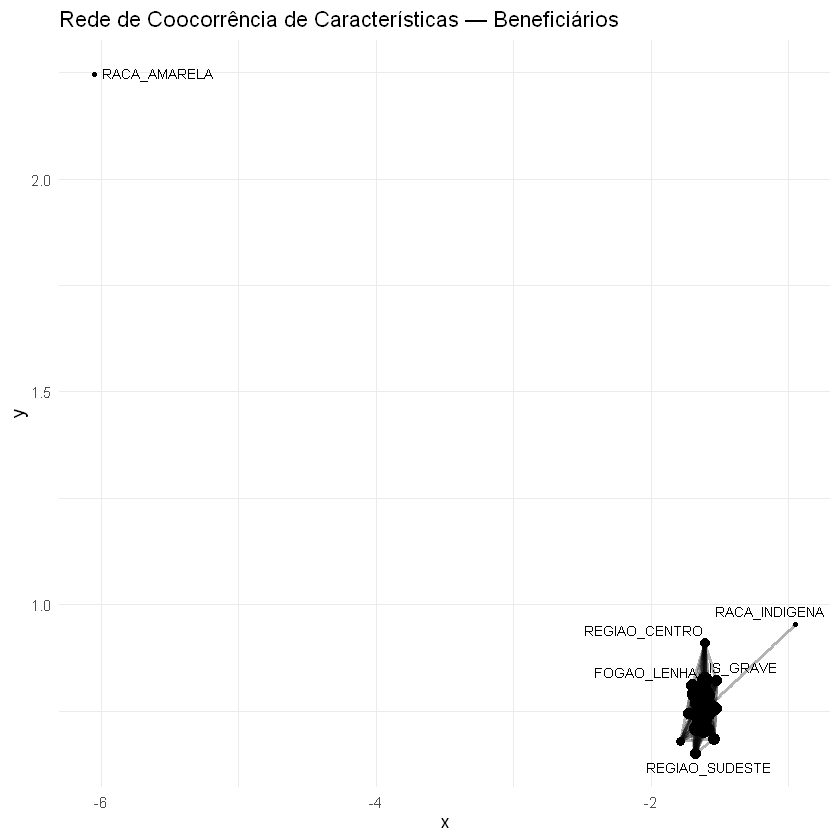

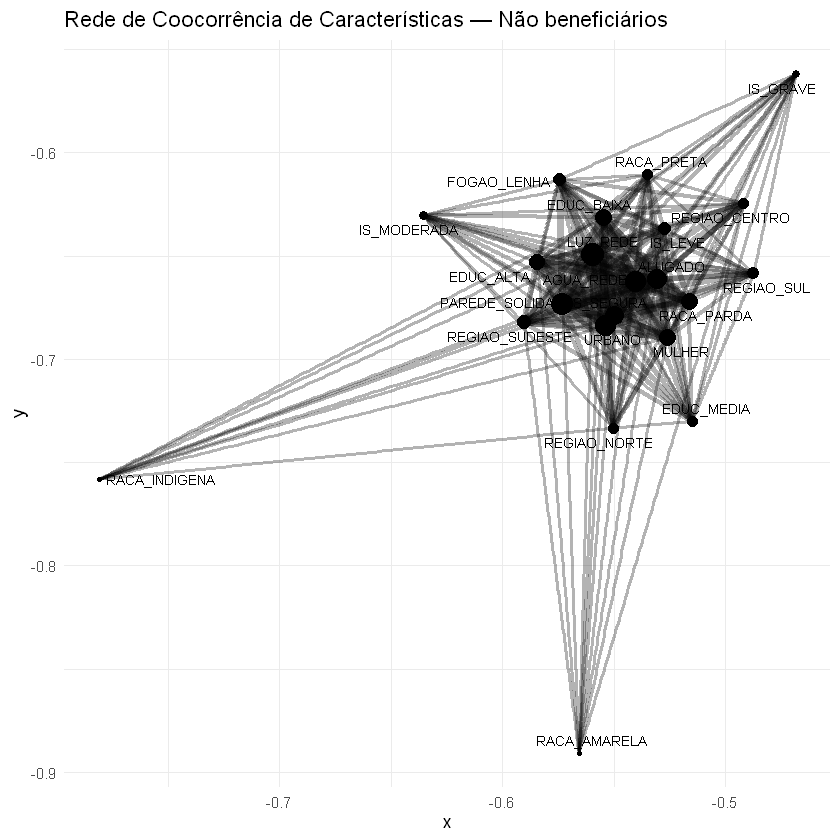

In [33]:
plot_network <- function(g, title_txt) {
  ggraph(g, layout = "fr") +
    geom_edge_link(aes(width = weight), alpha = 0.3) +
    geom_node_point(aes(size = strength(g, weights = E(g)$weight))) +
    geom_node_text(aes(label = name), repel = TRUE, size = 3) +
    theme_minimal() +
    labs(title = title_txt) +
    guides(edge_width = "none", size = "none")
}

plot_network(g_benef_proj, "Rede de Coocorrência de Características — Beneficiários")
plot_network(g_nao_benef_proj, "Rede de Coocorrência de Características — Não beneficiários")

#### Análise Gráfico 1: Rede de Coocorrência de Características — Beneficiários do Bolsa Família

* Estrutura geral da rede

A visualização indica uma rede menos densa e mais concentrada em um núcleo central, com alguns nós periféricos ou relativamente isolados. Isso é consistente com as métricas estruturais previamente apresentadas, que apontaram menor densidade e presença de mais de um componente na rede dos beneficiários.

* Núcleo central de características

Observa-se um agrupamento central fortemente conectado, composto majoritariamente por características relacionadas à infraestrutura domiciliar e à condição urbana, como acesso à energia elétrica, paredes sólidas e localização urbana. Esse núcleo sugere que, entre os beneficiários, essas condições tendem a coexistir de forma recorrente.

* Posicionamento da insegurança alimentar

A insegurança alimentar grave (IS_GRAVE) aparece integrada ao núcleo principal, mas sem ocupar posição claramente dominante. Isso sugere que, embora a insegurança alimentar esteja associada a outras vulnerabilidades, ela não estrutura sozinha a rede, indicando uma distribuição mais difusa da privação entre beneficiários.

* Nós periféricos e baixa conectividade

Características como RACA_AMARELA e RACA_INDIGENA surgem em posições periféricas, com menor número de conexões. Esse padrão reflete sua menor frequência relativa na amostra e indica que essas características não participam de forma central da estrutura relacional predominante.

* Interpretação geral

A rede dos beneficiários sugere uma estrutura relacional menos compacta, na qual as vulnerabilidades socioeconômicas não se acumulam de forma tão sistemática. Esse padrão é compatível com a hipótese de que o Programa Bolsa Família contribui para reduzir a sobreposição intensa de desvantagens.

#### Análise Gráfico 2: Rede de Coocorrência de Características — Não beneficiários

* Estrutura geral da rede

A visualização revela uma rede mais densa, compacta e fortemente interconectada, com praticamente todos os nós integrados em um único componente. Esse padrão visual confirma os resultados quantitativos de maior densidade e ausência de fragmentação estrutural.

* Centralidade do núcleo socioeconômico

O núcleo da rede é composto por características de infraestrutura, escolaridade, condição urbana e raça, formando um bloco altamente conectado. A proximidade visual entre esses nós indica elevada coocorrência, sugerindo uma estrutura socioeconômica mais homogênea entre os não beneficiários.

* Posição da segurança e insegurança alimentar

Diferentemente da rede dos beneficiários, observa-se maior integração tanto da segurança alimentar (IS_SEGURA) quanto da insegurança alimentar grave (IS_GRAVE) ao núcleo da rede. Isso sugere que, entre os não beneficiários, a condição alimentar está fortemente associada às demais características estruturais, funcionando como um marcador central do perfil socioeconômico.

* Conectividade de características demográficas

Variáveis como MULHER, RACA_PARDA e níveis educacionais apresentam múltiplas conexões com o núcleo central, indicando que fatores demográficos se articulam de forma mais consistente e integrada às condições materiais nesse grupo.

* Interpretação geral

A rede dos não beneficiários evidencia uma estrutura relacional mais consolidada, na qual características socioeconômicas tendem a ocorrer conjuntamente de maneira intensa. Esse padrão sugere maior acumulação estrutural de atributos, tanto favoráveis quanto desfavoráveis, em comparação ao observado entre beneficiários.

#### Síntese comparativa dos dois gráficos

* A rede dos beneficiários apresenta maior dispersão e presença de nós periféricos, indicando menor sobreposição sistemática de vulnerabilidades.

* A rede dos não beneficiários é mais compacta e integrada, refletindo maior coocorrência estrutural entre características socioeconômicas.

* Visualmente, os resultados reforçam a interpretação de que o Programa Bolsa Família está associado a uma reorganização da estrutura relacional das vulnerabilidades, reduzindo a concentração de desvantagens em um único núcleo.

## <> Comunidades (clusters) e visualização por grupo

Warning message:
"ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


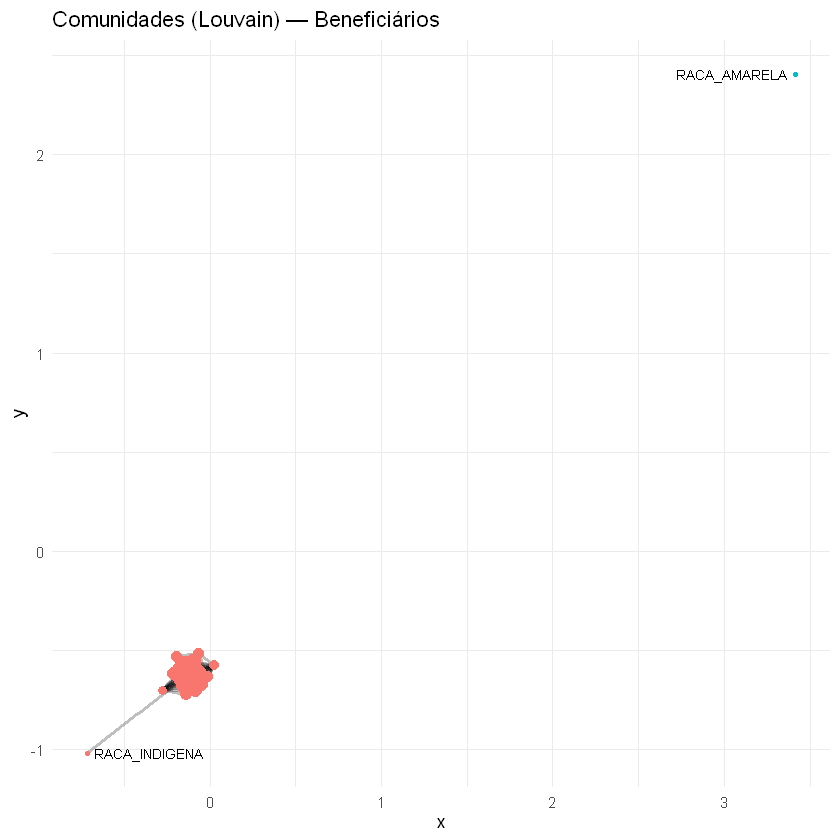

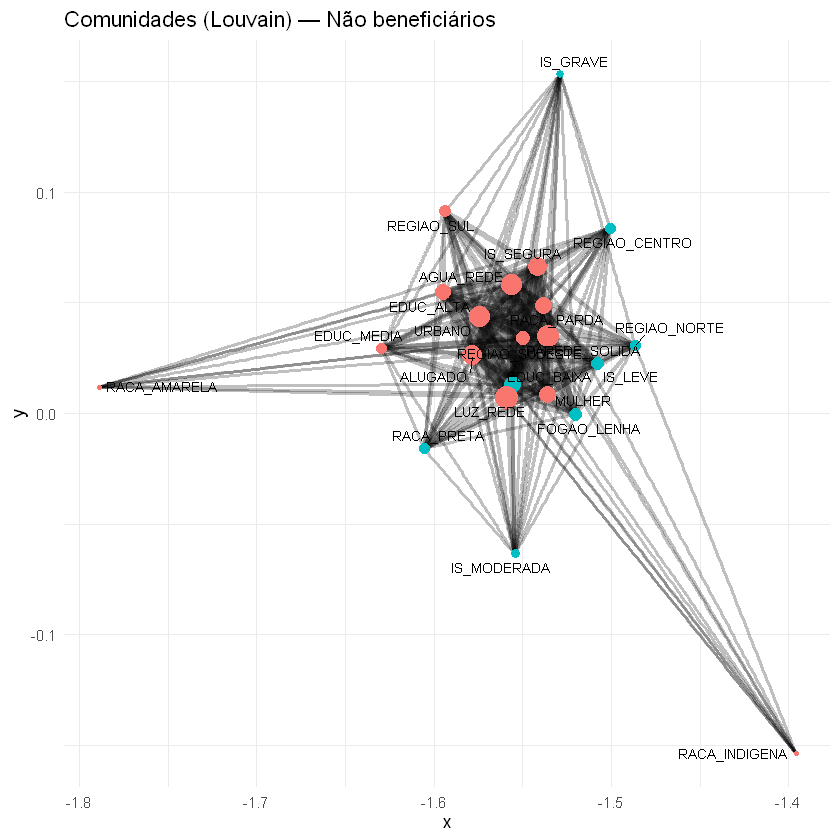

In [34]:
plot_communities <- function(g, title_txt) {
  cl <- cluster_louvain(g, weights = E(g)$weight)
  V(g)$community <- as.factor(membership(cl))

  ggraph(g, layout = "fr") +
    geom_edge_link(aes(width = weight), alpha = 0.25) +
    geom_node_point(aes(size = strength(g, weights = E(g)$weight), color = community)) +
    geom_node_text(aes(label = name), repel = TRUE, size = 3) +
    theme_minimal() +
    labs(title = title_txt) +
    guides(edge_width = "none", size = "none", color = "none")
}

plot_communities(g_benef_proj, "Comunidades (Louvain) — Beneficiários")
plot_communities(g_nao_benef_proj, "Comunidades (Louvain) — Não beneficiários")

#### Análise Gráfico 1: Comunidades na rede de beneficiários do Bolsa Família

* Estrutura de comunidades

A visualização indica a formação de um grande agrupamento central dominante, no qual se concentram praticamente todas as características socioeconômicas relevantes. Isso é consistente com a modularidade próxima de zero observada anteriormente, indicando fraca segmentação comunitária.

* Ausência de clusters bem definidos

O algoritmo de Louvain não identifica comunidades claramente separadas, sugerindo que as características se organizam em uma estrutura relacional contínua, sem blocos socioeconômicos fortemente diferenciados entre os beneficiários.

* Nós periféricos isolados

Variáveis como RACA_AMARELA e RACA_INDIGENA aparecem visualmente afastadas do núcleo principal, formando pontos periféricos ou quase isolados. Esse padrão reflete sua baixa frequência na amostra e limitada coocorrência com outras características.

* Integração da insegurança alimentar

As categorias de insegurança alimentar aparecem incorporadas ao núcleo principal, sem formar comunidades próprias. Isso indica que, entre beneficiários, a insegurança alimentar não constitui um eixo segregador, mas se articula de forma difusa às demais condições socioeconômicas.

* Interpretação geral

A ausência de clusters bem delimitados sugere que o Bolsa Família está associado a uma homogeneização relacional das vulnerabilidades, reduzindo a formação de subgrupos socioeconômicos claramente diferenciados.

#### Análise Gráfico 2: Comunidades na rede de não beneficiários

* Estrutura comunitária mais complexa

A visualização revela a presença de múltiplos agrupamentos sobrepostos, ainda que sem separações muito nítidas. Isso indica uma estrutura relacional ligeiramente mais segmentada do que a observada entre beneficiários.

* Núcleo central multifatorial

O núcleo da rede agrupa características de infraestrutura (LUZ_REDE, AGUA_REDE, PAREDE_SOLIDA), condição urbana, escolaridade e variáveis regionais, formando uma comunidade central altamente conectada.

* Papel da insegurança alimentar

Diferentemente da rede dos beneficiários, observa-se que IS_GRAVE e IS_MODERADA ocupam posições mais destacadas e conectadas, aproximando-se de diferentes subconjuntos da rede. Isso sugere que, entre não beneficiários, a insegurança alimentar atua como um fator relacional mais estruturante.

* Nós periféricos e especialização

Variáveis de baixa frequência, como RACA_AMARELA e RACA_INDIGENA, permanecem periféricas, mas com maior número de conexões do que no caso dos beneficiários, indicando maior integração relativa à estrutura geral.

* Interpretação geral

A presença de múltiplos agrupamentos indica que, entre não beneficiários, os perfis socioeconômicos tendem a se organizar em configurações mais diferenciadas, refletindo maior heterogeneidade estrutural.

#### Síntese comparativa dos dois gráficos

* Entre beneficiários, as comunidades são pouco definidas, com predominância de um único agrupamento central.

* Entre não beneficiários, observa-se maior complexidade relacional, com múltiplos agrupamentos parcialmente diferenciados.

* Esses resultados reforçam a interpretação de que o Programa Bolsa Família está associado a uma redução da segmentação estrutural, promovendo maior integração relacional entre características socioeconômicas.

## 2.6 Síntese dos Resultados e Implicações da Análise de Redes Sociais

* A Análise de Redes Sociais evidenciou diferenças estruturais relevantes entre os perfis socioeconômicos de domicílios beneficiários e não beneficiários do Programa Bolsa Família, mesmo a partir de um conjunto idêntico de características, permitindo comparabilidade direta entre as redes.

* A rede dos beneficiários apresentou menor densidade, maior heterogeneidade estrutural e presença de mais de um componente, indicando menor coocorrência sistemática de características socioeconômicas e menor acumulação relacional de vulnerabilidades.

* Em contraste, a rede dos não beneficiários mostrou-se mais densa, integrada e homogênea, sugerindo maior sobreposição estrutural de atributos socioeconômicos, tanto favoráveis quanto desfavoráveis.

* A infraestrutura domiciliar básica (acesso à energia elétrica, água encanada e condições habitacionais) emergiu como o principal eixo estruturante em ambos os grupos, indicando que fatores materiais continuam a desempenhar papel central na organização dos perfis socioeconômicos, independentemente da condição de recebimento do benefício.

* Entre os beneficiários, a insegurança alimentar, especialmente em sua forma leve, aparece integrada à estrutura relacional, mas sem ocupar posição central dominante, sugerindo que o Programa Bolsa Família está associado a uma reorganização das relações entre vulnerabilidades, reduzindo sua concentração em um único núcleo.

* Entre os não beneficiários, tanto a segurança quanto a insegurança alimentar ocupam posições mais centrais na rede, refletindo maior associação direta com as demais características estruturais.

* A análise de comunidades revelou ausência de clusters bem delimitados entre beneficiários, indicando uma estrutura relacional mais integrada e menos segmentada, enquanto entre os não beneficiários observou-se maior complexidade comunitária e diferenciação parcial de perfis.

* Do ponto de vista metodológico, os resultados demonstram a aplicabilidade e o potencial analítico da Análise de Redes Sociais aplicada a microdados socioeconômicos, complementando abordagens tradicionais de avaliação de políticas públicas ao capturar a organização estrutural das vulnerabilidades.

* Em termos de políticas públicas, os achados sugerem que programas de transferência de renda podem contribuir para a reconfiguração relacional das vulnerabilidades, ainda que não substituam políticas estruturais voltadas à provisão de infraestrutura e serviços básicos.